### <span style="color:rgb(92,29,79)">Optimization for Machine Learning</span>

### <span style="color:rgb(92,29,79)">Master 2 ID Apprentissage 2024-2025</span>


# <span style="color:rgb(92,29,79)">Lab 03 - Stochastic gradient</span>

Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OID/PolyOID.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OID/LabOID03.zip). The solution notebook will be available after the lab session [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OID/LabOID03-solutions.zip).


For any comment regarding this notebook (including typos), please send an email to:  **clement.royer@lamsade.dauphine.fr**.

# <span style="color:rgb(92,29,79)">Introduction</span>

The goal of this session is to illustrate and confirm the interest of stochastic gradient techniques on finite-sum problems. To this end, we will rely on the finite-sum optimization problems with synthetic data that we already considered in the previous lab sessions.

In [ ]:
# Import useful librairies and functions
###############################################

# Plots

%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root

# NumPy - Vector and matrix structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform, choice # Probability distributions


# SciPy - Efficient numerical calculations
from scipy.linalg import norm # Standard norms
from scipy.linalg import toeplitz # Toeplitz matrices
from scipy.linalg import svdvals # Singular value decomposition (recall Lecture 2!)
from scipy.optimize import check_grad # Numerical check of derivatives
from scipy.optimize import fmin_l_bfgs_b # An efficient minimization routine in moderate dimensions

# <span style="color:rgb(92,29,79)">Part 1 - Data and finite-sum formulations</span>



## <span style="color:rgb(92,29,79)">1.1 - Data generation</span>

Following the lectures, we consider a dataset $\{(\mathbf{x}_i,y_i)\}_{i=1,\dots,n}$, where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$ under the form of

- a feature matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$;
- a label vector $\mathbf{y} \in \mathbb{R}^n$.

Our goal is to learn a mapping from $\mathbf{X}$ to $\mathbf{y}$. We consider that such a mapping or model, denoted by $h$, is parameterized by a vector $\mathbf{w}$, and the accuracy of the model is measured according to a loss function $\ell$. As a result, we will consider problems of the form
$$
    \mathrm{minimize}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{w}), \qquad f_i(\mathbf{w}) = \ell(h(\mathbf{x}_i;\mathbf{w}),y_i) + \frac{\lambda}{2}\|\mathbf{w}\|^2.
$$
where $\lambda \ge 0$ is an optional regularization parameter.

The dataset will be generated using the following procedure, that promotes correlation between the samples.

In [ ]:
# Generate data for linear models. This code is based on a generator proposed by Alexandre Gramfort (INRIA).
def simu_lin(wtruth, n, std=1., corr=0.5):
    """
    Generation of data from a linear trend corrupted by Gaussian noise.

    Inputs
    ----------
    wtruth: np.ndarray, shape=(d,)
        Ground truth coefficients

    n: int
        Sample size

    std: float, default=1.
        Standard deviation for the noise

    corr: float, default=0.5
        Correlation for the feature matrix

    Outputs
    ------------
    X: Feature matrix
    y: Label vector

    """
    d = wtruth.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    # Main relationship
    y = X.dot(wtruth) + noise
    return X, y

The data is generated by a linear ground truth plus (Gaussian) noise, resulting in data this is quite favorable to stochastic gradient techniques.

## <span style="color:rgb(92,29,79)">1.2 Linear regression</span>

We first investigate the prediction of $y_i$ from $\mathbf{x}_i$ using a linear model, giving rise to the following linear least-squares optimization problem:
$$
    \mathrm{minimize}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w})
    := \frac{1}{2 n} \|\mathbf{X} \mathbf{w} - \mathbf{y}\|^2 + \frac{\lambda}{2}\|\mathbf{w}\|^2.
$$
Note that the objective function of this problem is slightly modified compared to the one we studied in previous lab sessions. Nevertheless, it remains a linear least-squares objective and, as such, it is $\mathcal{C}^1$.

Moreover, this problem has a finite-sum structure $f(\mathbf{w})=\tfrac{1}{n}\sum_{i=1}^n f_i(\mathbf{w})$, where
$$
    f_i(\mathbf{w}) = \frac{1}{2} (\mathbf{x}_i^T \mathbf{w} - y_i)^2 + \frac{\lambda}{2} \|\mathbf{w}\|^2.
$$
One can show that all $f_i$s are $\mathcal{C}^1$, which implies that $f$ is also $\mathcal{C}^1$. In addition, one has
$$
    \nabla f_i(\mathbf{w}) = (\mathbf{x}_i^T \mathbf{w} - y_i)\mathbf{x}_i + \lambda \mathbf{w}
$$
for any $i=1,\dots,n$ and
$$
    \nabla f(\mathbf{w}) =\frac{1}{n}\mathbf{X}^T (\mathbf{X} \mathbf{w} - \mathbf{y}) + \lambda\mathbf{w}.
$$
Finally, $\nabla f$ is $\left(\frac{\|\mathbf{X}^T \mathbf{X}\|}{n}+\lambda\right)$-Lipschitz continuous.

## <span style="color:rgb(92,29,79)">1.3 Logistic regression</span>

In logistic regression, we aim at predicting a binary label (in our case $y_i \in \{-1,1\}$ ) from $\mathbf{x}_i$ using a linear model (or rather the sign of a linear function) of $\mathbf{x}_i$.

These considerations give rise to the following model:
$$
    \mathrm{minimize}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w})
    := \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{w}), \qquad
    f_i(\mathbf{w})=\log(1+\exp(-y_i \mathbf{x}_i^T \mathbf{w}))+\frac{\lambda}{2}\|\mathbf{w}\|^2,
$$
where every $y_i$ belong to$\{-1,1\}$ and the second term in the objective is again a regularization one.

This problem has a natural finite-sum structure, and we can show that $f_i \in \mathcal{C}^1(\mathbb{R}^d)$ for all $i$ as well as $f \in \mathcal{C}^{1,1}_L(\mathbb{R}^d)$, where
$$
   \forall i=1,\dots,n, \quad \nabla f_i(\mathbf{w}) = - \frac{y_i}{1 + \exp(y_i \mathbf{x}_i^T \mathbf{w})} \mathbf{x}_i + \lambda \mathbf{w},
$$
$$
\nabla f(\mathbf{w}) = - \frac{1}{n} \sum_{i=1}^n\frac{y_i}{1 + \exp(y_i \mathbf{x}_i^T \mathbf{w})} \mathbf{x}_i + \lambda \mathbf{w}
$$
and
$$
    L=\frac{\|\mathbf{X}^T \mathbf{X}\|}{4n}+\lambda.
$$

## <span style="color:rgb(92,29,79)">1.4 Python class for regression problems</span>

The code below implements regression problems while accounting for their finite-sum structure.

*Recall:* For any two-dimensional NumPy array ``X``, ``X[i]`` denotes the $i$th row of ``X``. For any vector ``x``, ``x.dot(v)`` denotes the scalar product between ``x`` and ``v``, while ``x.T`` is the transpose of ``x``.

In [ ]:
class RegPb(object):
    '''
        A class for linear and logistic regression based on linear models.

        Describes an optimization problem of the form

            minimize_w loss(w) + lbda*||w||^2,

        where loss is a given function that is defined based on data.

        Attributes:
            X: Feature matrix
            y: Label vector
            n,d: Dimensions of X
            loss: Loss function
                'l2': Least-squares loss
                'logit': Logistic loss based on softplus
            lbda: "Strong convexification"/Regularization parameter

        Methods:
            fun: Returns the objective value at a given point w
            grad: Returns the gradient value at a given point w
            lipgrad: Lipschitz constant for the gradient
            cvxval: Returns the strong convexity constant if the objective function is strongly convex, 0 otherwise.

    '''

    # Instantiate the class
    def __init__(self, X, y,lbda=0,loss='l2'):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.loss = loss
        self.lbda = lbda


    #Objective function
    def fun(self, w):
        if self.loss=='l2':
            return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            return np.mean(np.log(1. + np.exp(-yXw))) + self.lbda * norm(w) ** 2 / 2.

    # Value of one term in the sum
    def f_i(self, i, w):
        if self.loss=='l2':
            return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.
        elif self.loss=='logit':
            yXwi = self.y[i] * np.dot(self.X[i], w)
            return np.log(1. + np.exp(- yXwi)) + self.lbda * norm(w) ** 2 / 2.

    # Gradient of the objective
    def grad(self, w):
        if self.loss=='l2':
            return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            aux = 1. / (1. + np.exp(yXw))
            return - (self.X.T).dot(self.y * aux) / self.n + self.lbda * w

    # Gradient of one term in the finite sum
    def grad_i(self,i,w):
        x_i = self.X[i]
        if self.loss=='l2':
            return (x_i.dot(w) - self.y[i]) * x_i + self.lbda*w
        elif self.loss=='logit':
            grad = - x_i * self.y[i] / (1. + np.exp(self.y[i]* x_i.dot(w)))
            grad += self.lbda * w
            return grad

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.X, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L

    # "Strong" convexity constant (possibly zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.X)
            mu = min(s)**2 / self.n
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

We now generate one instance of linear regression and one instance of logistic regression. Note that in our setting, we use $$d=50 \ll n=1000.$$

In [ ]:
# Instance generation
d = 50
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# Fix random seed for reproducibility
np.random.seed(0)

# Ground truth
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

Xlin, ylin = simu_lin(w_model_truth, n, std=1., corr=0.1)
Xlog, ylog = simu_lin(w_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog) # Logarithm for binary classification

pblinreg = RegPb(Xlin, ylin,lbda,loss='l2')
pblogreg = RegPb(Xlog, ylog,lbda,loss='logit')

Given the dimensions of the problem ($d=50,n=1000$), we can apply a powerful optimization technique to obtain a target optimal value and a target optimal point. *Recall that in a big data setting, this method would be too expensive to use.*

In [ ]:
# Use L-BFGS to get a good approximation for the minimum

w_init = np.zeros(d)

# Compute a solution for linear regression using L-BFGS
w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, w_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print("Linear regression:")
print("\t Numerical minimal value:",f_min_lin)
print("\t Numerical minimum gradient norm:",norm(pblinreg.grad(w_min_lin)))
# Compute a solution for logistic regression using L-BFGS
w_min_log, f_min_log, _ = fmin_l_bfgs_b(pblogreg.fun, w_init, pblogreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print("Logistic regression:")
print("\t Numerical minimal value:",f_min_log)
print("\t Numerical minimum gradient norm:",norm(pblogreg.grad(w_min_log)))

Linear regression:
	 Numerical minimal value: 0.5609973667736611
	 Numerical minimum gradient norm: 5.238598430060513e-09
Logistic regression:
	 Numerical minimal value: 0.5621593875942845
	 Numerical minimum gradient norm: 2.576247290912413e-09


Letting $f^*$ and $\mathbf{w}^*$ denote the values computed via L-BFGS, and letting $\{\mathbf{w}_k\}$ denote the iterate sequence of a given method, we will be interested in the behavior of
$f(\mathbf{w}_k)-f^*$ and $\|\mathbf{w}_k -\mathbf{w}^*\|$ as $k$ increases.

# <span style="color:rgb(92,29,79)">Part 2 - Stochastic gradient methods</span>

In this part, we build a generic stochastic gradient method that will allow for comparing several variants thereof.

## <span style="color:rgb(92,29,79)"> 2.1 Basic stochastic gradient framework</span>

One iteration of stochastic gradient (also called *Stochastic Gradient Descent* or *SGD*) is given by
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla f_{i_k}(\mathbf{w}_k),
$$
where $i_k$ is drawn at random in $\{1,\dots,n\}$. In this notebook, we will draw $i_k$ according to a uniform distribution (i.e. every value has probability $\tfrac{1}{n}$ of being drawn).

A more general version of this method called *batch stochastic gradient* is given by
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \frac{\alpha_k}{|\mathcal{S}_k|} \sum_{i \in \mathcal{S}_k} \nabla f_i(\mathbf{w}_k)
$$
where $\mathcal{S}_k$ is a set of indices randomly drawn in $\{1,\dots,n\}$. In this notebook, we will consider both draws with and withour replacement. Drawing a subset of cardinality $|\mathcal{S}_k|=n$ corresponds to performing gradient descent, while using $|\mathcal{S}_k|=1$ (with or without replacement at the iteration) corresponds to standard stochastic gradient. For simplicity, we will focus on using a constant batch size.

### <span style="color:rgb(92,29,79)">Question 1</span>

*Recall the cost of a batch stochastic gradient iteration in terms of accesses to data points.*

#### <span style="color:rgb(92,29,79)">Answer to question 1</span>

1 iteration = $\frac{|\mathcal{S}_k|}{n}$ epoch = $|\mathcal{S}_k|$ accesses to a data point

### <span style="color:rgb(92,29,79)">Question 2</span>

Recall the definition of an epoch. How does this notion allows for comparing different variants of batch stochastic gradient?

#### <span style="color:rgb(92,29,79)">Answer to question 2</span>



### <span style="color:rgb(92,29,79)">Question 3</span>

The code below implements stochastic gradient (in batch version) with two possible choises for the stepsize
 - $\alpha_k=\tfrac{1}{L}$ (constant);
 - $\alpha_k=\frac{\alpha_0}{(k+1)^t}$, where $\alpha_0$ and $t>0$ (decreasing).

***Fill out the code block below.***

*Useful NumPy function:* ``np.random.choice(n,m,replace=False)`` draws $m$ values uniformly in $\{1,\dots,n\}$ without replacement.

In [6]:
# Imlementation of stochastic gradient techniques
def stoch_grad(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,with_replace=False,verbose=False):
    """
        Stochastic gradient framework.

        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() is the objective function (a finite sum)
                problem.n returns the number of terms within the sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns a Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant for the problem
                problem.lambda returns the regularization parameter
            wtarget: Target value
            stepchoice: Stepsize/Learning rate strategy
                0: Constant stepsize equal to 1/L
                t>0: Stepsize proportional to 1/(k+1)**t
            step0: Initial stepsize (used when stepchoice>0)
            n_iter: Number of iterations
            nb: Batch size (Default: 1)
            with_replace: Drawing indices with/without replacement
                True: With replacement
                False: Without replacement (Default)
            verbose: Boolean indication whether epoch-related info are to be displayedées à chaque epoch (default : False)

        Outputs :
            w_output: Final iterate
            objvals: History of function values (NumPy array of length n_iter)
            distits: History of distance to optimal point (NumPy array of length n_iter)
    """
    ############
    # Initialization

    # History of function values and distance to a theoretical optimum
    objvals = []
    normits = []

    # Lipschitz constant
    L = problem.lipgrad()

    # Size of the dataset
    n = problem.n

    # Initial value for the iterate
    w = w0.copy()
    nw = norm(w)

    # Iteration
    k=0

    # Initial quantities of interest
    obj = problem.fun(w)
    objvals.append(obj);
    nmin = norm(w-wtarget)
    normits.append(nmin)

    if verbose:
        # Plotting info if required
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    ################
    # Main loop
    while (k < n_iter and nw < 10**100):

        ########
        # THIS SECTION SHOULD BE FILLED OUT

        # Draw random index or indices
        indices = np.random.choice(n, size=nb, replace=with_replace)

        # Compute the stochastic gradient approximation
        sg = np.zeros_like(w)
        for i in indices:
            sg += problem.grad_i(i, w)

        sg /= nb  # Average the gradient over the batch
        # END PART TO BE FILLED OUT
        #######

        if stepchoice==0:
            w[:] = w - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            w[:] = w - sk * sg

        nw = norm(w) #Compute the norm of the iterate (prevents divergence)

        obj = problem.fun(w)
        nmin = norm(w-wtarget)

        k += 1
        # Compute quantities of interest at the end of every epoch
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    # End main loop
    #################

    # Final information
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    # Outputs
    w_output = w.copy()

    return w_output, np.array(objvals), np.array(normits)

## <span style="color:rgb(92,29,79)"> 2.2 Gradient descent VS stochastic gradient</span>

The script below compares stochastic gradient and gradient descent on logistic regression given a budget of 60 epochs. For both methods, two stepsize choices are considered: $\alpha_k = \tfrac{1}{L}$ and $\alpha_k = \tfrac{0.2}{\sqrt{k+1}}$.

In [7]:
# Comparison gradient descent/stochastic gradient
# Note: the number of iterations of each method depends on the cost
# of a method's iteration
nb_epochs = 60
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

# Run a - Gradient descent with constant stepsize
w_a, obj_a, nits_a = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0,step0=1, n_iter=nb_epochs,nb=n)

# Run b - Stochastic gradient with constant stepsize
# This instance can diverge, hence the use of a bound on norm(w)
w_b, obj_b, nits_b = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0,step0=1, n_iter=int(nb_epochs*n/nbset),nb=1)

# Run c - Gradient descent with decreasing stepsize
w_c, obj_c, nits_c = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0.5,step0=0.2, n_iter=nb_epochs,nb=n)
# Run d - Stochastic gradient with decreasing stepsize
w_d, obj_d, nits_d = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)

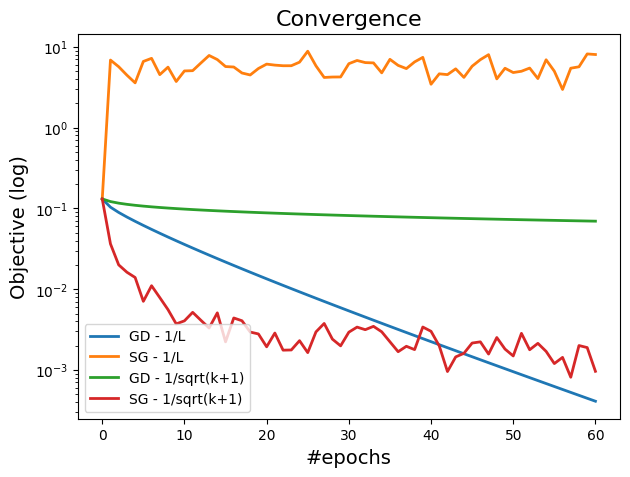

In [8]:
# Plot the behavior of the four methods
# The x-axis corresponds to the number of epochs
# The y-axis corresponds to the objective function (semilog scale)

plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_log, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_log, label="SG - 1/L", lw=2)
plt.semilogy(obj_c-f_min_log, label="GD - 1/sqrt(k+1)", lw=2)
plt.semilogy(obj_d-f_min_log, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend()

### <span style="color:rgb(92,29,79)">Question 4</span>

*According to the theoretical analysis, how can we explain the behavior of both stochastic gradient variants?*

#### <span style="color:rgb(92,29,79)">Answer to question 4</span>

...

## <span style="color:rgb(92,29,79)"> 2.3 Stochastic gradient and stepsize</span>

One of the key challenges in stochastic gradient is the tuning of the stepsize (also called *learning rate* in machine learning). The script below compares several values that are proportional to $\frac{1}{L}$, the canonical choice for gradient descent.

In [9]:
# Comparison of several constant learning rate choices

nb_epochs = 60
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

valsstep0 = [1,0.1,0.01,0.001,0.0001]
nvals = len(valsstep0)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0,step0=valsstep0[val], n_iter=int(nb_epochs*n/nbset),nb=1)


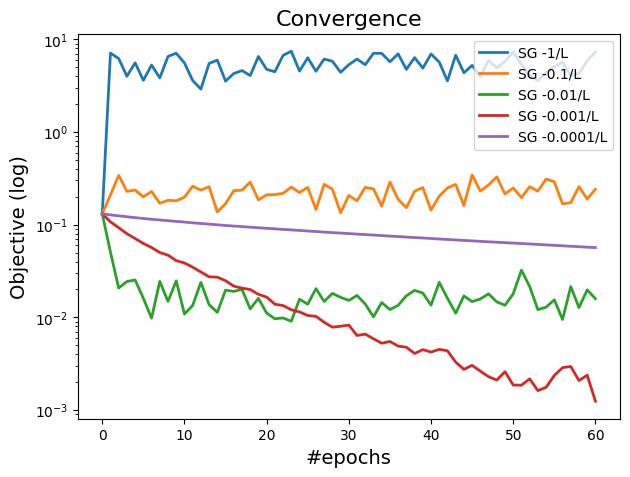

In [10]:
# Plot the behavior of all methods
# The x-axis corresponds to the number of epochs
# The y-axis corresponds to the objective function (semilog scale)
plt.figure(figsize=(7, 5))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_log, label="SG -"+str(valsstep0[val])+"/L", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend(loc=1)

We also compare several choices for a decreasing stepsize.

Starting from $\alpha_0>0$, we also consider $\tfrac{\alpha_0}{\sqrt{k+1}}$, $\tfrac{\alpha_0}{k+1}$, $\tfrac{\alpha_0}{(k+1)^{1/4}}$, $\tfrac{\alpha_0}{(k+1)^{2/3}}$.

In [11]:
# Comparison of several decreasing learning rate choices

nb_epochs = 60
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

decstep = [1,2/3,1/2,1/4,0]
nvals = len(decstep)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(w0,pblogreg,w_min_log,stepchoice=decstep[val],step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=1)

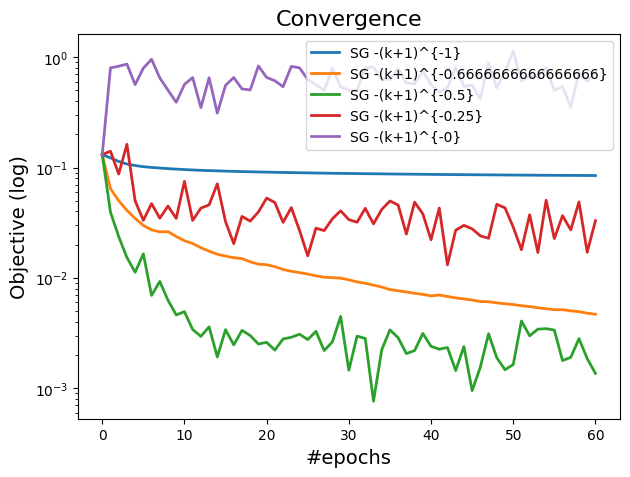

In [12]:
# Plot the behavior of all methods
# The x-axis corresponds to the number of epochs
# The y-axis corresponds to the objective function (semilog scale)
plt.figure(figsize=(7, 5))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_log, label="SG -(k+1)^{-"+str(decstep[val])+"}", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend(loc=1)

### <span style="color:rgb(92,29,79)">Question 5</span>

*Based on what we saw during the lectures, how can we explain these observations?*

#### <span style="color:rgb(92,29,79)">Answer to question 5</span>

...

## <span style="color:rgb(92,29,79)"> 2.4 Choosing the batch size</span>

The script below compares several versions of batch stochastic gradient with their own batch size $n_b$. We consider $n_b \in \left\{1,\tfrac{n}{100},\tfrac{n}{10},\tfrac{n}{2},n \right\}$ in order to cover ($n_b=1$) and gradient descent ($n_b=n$ without replacement).

In [ ]:
# Comparison of several batch sizes

nb_epochs = 100
n = pblogreg.n
w0 = np.zeros(d)

replace_batch=False

# Stochastic gradient (batch size=1)
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Batch stochastic gradient (batch size=n/100)
nbset=int(n/100)
w_b, obj_b, nits_b = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Batch stochastic gradient (batch size=n/10)
nbset=int(n/10)
w_c, obj_c, nits_c = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Batch stochastic gradient (batch size=n/2)
nbset=int(n/2)
w_d, obj_d, nits_d = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)

# Gradient descent (batch size=n, indices drawn without replacement)
w_f, obj_f, nits_f = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs),nb=n)

In [ ]:
# Results of the comparison

# In terms of objective function (log)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG (batch=1)", lw=2)
plt.semilogy(obj_b-f_min_lin, label="Batch SG - n/100", lw=2)
plt.semilogy(obj_c-f_min_lin, label="Batch SG - n/10", lw=2)
plt.semilogy(obj_d-f_min_lin, label="Batch SG - n/2", lw=2)
plt.semilogy(obj_f-f_min_lin, label="GD", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend()

### <span style="color:rgb(92,29,79)">Question 6</span>

*Comment on the results, and the various regimes observed as a function of the batch size.*

#### <span style="color:rgb(92,29,79)">Answer to question 6</span>

...

## <span style="color:rgb(92,29,79)">2.5 Variance reduction and batch approaches</span>

In this last part, we investigate multiple runs of (batch) stochastic gradient methods. Recall that those methods are random in nature, implying that the outcome of a specific realization depends on a realization of a random process. Our goal is to study the variability of these realizations.

### <span style="color:rgb(92,29,79)">Question 7</span>

Run the code below to run several runs of batch stochastic gradient with stepsize
$\frac{0.2}{\sqrt{k+1}}$. Explain how the resulting plot illustrates the variance reduction capabilities of batch stochastic gradient.

In [ ]:
# Test several values for the batch size using the same epoch budget.

nb_epochs = 100
n = pblinreg.n
w0 = np.zeros(d)

nruns = 10

for i in range(nruns):
    # Run standard stochastic gradient (batch size 1)
    _, obj_a, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,with_replace=True)
    # Batch stochastic gradient (batch size n/10)
    nbset=int(n/10)
    _, obj_b, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    # Batch stochastic gradient (batch size n/2)
    nbset=int(n/2)
    _, obj_c, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    # Batch stochastic gradient (batch size n, with replacement)
    nbset=n
    _, obj_d, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)

    # Plots runs on the same figure
    if i<nruns-1:
        plt.semilogy(obj_a-f_min_lin,color='orange',lw=2)
        plt.semilogy(obj_b-f_min_lin,color='green', lw=2)
        plt.semilogy(obj_c-f_min_lin,color='red', lw=2)
        plt.semilogy(obj_d-f_min_lin,color='blue', lw=2)
plt.semilogy(obj_a-f_min_lin,label="SG",color='orange',lw=2)
plt.semilogy(obj_b-f_min_lin,label="batch n/10",color='green',lw=2)
plt.semilogy(obj_c-f_min_lin,label="batch n/2",color='red', lw=2)
plt.semilogy(obj_d-f_min_lin,label="batch n",color='blue', lw=2)

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

#### <span style="color:rgb(92,29,79)">Answer to question 7</span>

...

# <span style="color:rgb(92,29,79)">Part 3 - Advanced variants of stochastic gradient</span>

The goal of this section is to present popular variants of the classical stochastic gradient scheme. The augmented code below aims at allowing iterate averaging and diagonal scaling to the method.

##  <span style="color:rgb(92,29,79)">3.1 SG variants based on diagonal scaling</span>

#### <span style="color:rgb(92,29,79)">A description of *RMSProp* and *Adagrad*</span>

*RMSProp* and *Adagrad* are both based on diagonal scaling. This corresponds to rescaling the stochastic gradient step componentwise as follows
 $$
     [\mathbf{w}_{k+1}]_i  = [\mathbf{w}_k]_i -\frac{\alpha}{\sqrt{[\mathbf{r}_k]_i + \epsilon}}[\nabla f_{i_k}(\mathbf{w}_k)]_i,
 $$
 where $\epsilon>0$ is added to avoid numerical issues, and $\mathbf{r}_k \in \mathbb{R}^d$ is defined recursively by $\mathbf{r}_{-1} = 0_{\mathbb{R}^d}$ and
 $$
     \forall k \ge 0,\ \forall i=1,\dots,d, \qquad
     [\mathbf{r}_k]_i =
     \left\{
         \begin{array}{ll}
             \beta_2 [\mathbf{r}_{k-1}]_i + (1-\beta_2) [\nabla f_{i_k}(\mathbf{w}_k)]_i^2 &\mathrm{for\ RMSProp,} \\
             [\mathbf{r}_{k-1}]_i + [\nabla f_{i_k}(\mathbf{w}_k)]_i^2 &\mathrm{for\ Adagrad.}
         \end{array}
     \right.
 $$
(Suggested values: $\epsilon=10^{-8}$, $\beta=0.8$.) The use of $\epsilon>0$ prevents the scaling of each component of the stochastic gradient from going to zero. *This technique is typically adopted in modern implementations of these methods.*

Batch variants of Adagrad and RMSProp can be obtained by replacing $\nabla f_{i_k}(\mathbf{w}_k)$ by a batch gradient estimate.

### <span style="color:rgb(92,29,79)">Question 8</span>

Fill out the code below with your implementation from question 1 as well as the diagonal scaling feature as done in RMSProp and Adagrad. To this end, use the parameter `scaling`, equal to $1$ for Adagrad, and to $\beta_2$ for RMSProp.

In [ ]:
# Advanced stochastic gradient implementation
def adv_stoch_grad(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,scaling=0,with_replace=False,verbose=False):
    """
        A code for gradient descent with various step choices.

        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize
                0: Constant step size equal to 1/L
                t>0: Step size decreasing in 1/(k+1)^t
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size
                1: Classical stochastic gradient algorithm (default value)
                problem.n: Classical gradient descent (default value)
            scaling: Use a diagonal scaling
                0: No scaling (default)
                (0,1): Average of magnitudes (RMSProp)
                1: Normalization with magnitudes (Adagrad)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)

        Outputs:
            w_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []

    # iterates distance to the minimum history
    normits = []

    # Lipschitz constant
    L = problem.lipgrad()

    # Number of samples
    n = problem.n

    # Initial value of current iterate
    w = w0.copy()
    nw = norm(w)

    #Scaling values
    if scaling>0:
        eps=10**(-8) # To avoid numerical issues
        v = np.zeros(d)

    # Initialize iteration counter
    k=0

    # Current objective
    obj = problem.fun(w)
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)

    # Plot initial quantities of interest
    if verbose:
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    ################
    # Main loop
    while (k < n_iter and nw < 10**100):

        #########################################
        # FILL OUT THIS PART WITH YOUR IMPLEMENTATION FROM QUESTION 1

        # Draw the batch indices
        # Stochastic gradient calculation
        sg =
        ###########################################

        ###########################################
        # ADD THE SCALING FEATURE
        if scaling>0:
            if scaling==1:
                # Adagrad update
                v =
            else:
                # RMSProp update
                v =
            sg =
        ##########################################

        if stepchoice==0:
            w[:] = w - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            w[:] = w - sk * sg

        nw = norm(w) #Computing the norm to measure divergence


        obj = problem.fun(w)
        nmin = norm(w-wtarget)


        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    # End of main loop
    #################

    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    # Outputs
    w_output = w.copy()

    return w_output, np.array(objvals), np.array(normits)

### <span style="color:rgb(92,29,79)">Question 9</span>

Run the script below to compare RMSProp and Adagrad using a decreasing stepsize $\frac{\alpha_0}{\sqrt{k+1}}$ or a constant stepsize with SG (use a decreasing stepsize for SG). What do you observe?

In [ ]:
# Question 9 - Comparison of stochastic gradient with and without diagonal scaling

nb_epochs = 60
n = pblinreg.n
w0 = np.zeros(d)

# Stochastic gradient (batch size 1) without diagonal scaling
w_a, obj_a, nits_a = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling (decreasing stepsize)
w_bd, obj_bd, nits_bd = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,scaling=1)
# Stochastic gradient (batch size 1) with RMSProp diagonal scaling (decreasing stepsize)
w_cd, obj_cd, nits_cd = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,scaling=0.8)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling (constant stepsize)
w_bc, obj_bc, nits_bc = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=0.2, n_iter=nb_epochs*n,nb=1,scaling=1)
# Stochastic gradient (batch size 1) with RMSProp diagonal scaling (constant stepsize)
w_cc, obj_cc, nits_cc = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=0.2, n_iter=nb_epochs*n,nb=1,scaling=0.8)


In [ ]:
# Plot the results - Comparison of stochastic gradient with and without diagonal scaling
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_bd-f_min_lin, label="Adagrad (dec)", lw=2)
plt.semilogy(obj_cd-f_min_lin, label="RMSProp (dec)", lw=2)
plt.semilogy(obj_bc-f_min_lin, label="Adagrad (cst)", lw=2)
plt.semilogy(obj_cc-f_min_lin, label="RMSProp (cst)", lw=2)
plt.title("SG vs Adagrad/RMSProp", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# In terms of distance to the minimum (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG", lw=2)
plt.semilogy(nits_bd, label="Adagrad (dec)", lw=2)
plt.semilogy(nits_cd, label="RMSProp (dec)", lw=2)
plt.semilogy(nits_bc, label="Adagrad (cst)", lw=2)
plt.semilogy(nits_cc, label="RMSProp (cst)", lw=2)
plt.title("SG vs Adagrad/RMSProp", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log scale)", fontsize=14)
plt.legend()

#### <span style="color:rgb(92,29,79)">Answer to question 9</span>

...

## <span style="color:rgb(92,29,79)">3.2 Stochastic gradient with momentum</span>

#### <span style="color:rgb(92,29,79)">A description of *SGD with momentum* and *Adam*</span>

Certain variants of stochastic gradient exploit the idea of momentum, i.e. they combine a classical stochastic gradient steps with steps from previous iterations.

*Stochastic gradient with momentum* can be viewed as the stochastic version of the heavy-ball method, and consists in the following iteration
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \mathbf{m}_k,
    \quad \mathrm{where} \quad
    \mathbf{m}_k = \beta_1 \mathbf{m}_{k-1} + (1-\beta_1)\nabla f_{i_k}(\mathbf{w}_k)
$$
where $\beta_1 \in (0,1)$ (using $\beta_1=0$ would give the standard stochastic gradient method).

*Adam* combines the momentum principle with diagonal scaling. That method accumulates information through all iterations. The update can be written as
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \mathbf{m}_k \oslash \sqrt{\mathbf{v}_k},
$$
where
$$
    \mathbf{m}_k = \frac{1-\beta_1^k}{1-\beta_1^{k+1}}\beta_1\mathbf{m}_{k-1} + \frac{1-\beta_1}{1-\beta_1^{k+1}}\nabla f_{i_k}(\mathbf{w}_k)
$$
and
$$
    \mathbf{v}_k = \frac{1-\beta_2^k}{1-\beta_2^{k+1}}\beta_2\mathbf{v}_{k-1} + \frac{1-\beta_2}{1-\beta_2^{k+1}}\nabla f_{i_k}(\mathbf{w}_k)\otimes\nabla f_{i_k}(\mathbf{w}_k).
$$

In practice, as in the previous section, we replace $\sqrt{\mathbf{v}_k}$ with $\sqrt{\mathbf{v}_k+\epsilon}$ for numerical stability.

### <span style="color:rgb(92,29,79)">Question 10</span>

Fill out the code below and run the next block to compare SG with momentum and Adam with
basic stochastic gradient. What do you observe?

In [ ]:
# Stochastic gradient technique with momentum
def stoch_grad_momentum(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,beta1=0.9,beta2=0.999,with_replace=False,verbose=False):
    """
        A code for stochastic gradient with various step choices.

        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize
                0: Constant step size equal to 1/L
                t>0: Step size decreasing in 1/(k+1)^t
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size
                1: Classical stochastic gradient algorithm (default value)
                problem.n: Classical gradient descent (default value)
            beta1: Momentum parameter for the direction
                0: Regular stochastic gradient
                (0,1): Momentum method (default: 0.9)
            beta2: Diagonal scaling parameter
                0: No scaling (SGD with momentum)
                (0,1): Geometric average (Adam, default: 0.999)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)

        Outputs:
            w_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []

    # iterates distance to the minimum history
    normits = []

    # Lipschitz constant
    L = problem.lipgrad()

    # Number of samples
    n = problem.n

    # Initial value of current iterate
    w = w0.copy()
    nw = norm(w)

    #Momentum vector
    mv = np.zeros(d)

    #Scaling values
    if beta2>0:
        eps=10**(-8) # To avoid numerical issues
        v = np.zeros(d)

    # Initialize iteration counter
    k=0

    # Current objective
    obj = problem.fun(w)
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)

    # Plot initial quantities of interest
    if verbose:
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    ################
    # Main loop
    while (k < n_iter and nw < 10**100):

        #########################################
        # FILL OUT THIS PART WITH YOUR IMPLEMENTATION FROM QUESTION 1
        # Draw the batch indices

        # Stochastic gradient calculation
        sg =
        ###########################################

        ###########################################
        # FILL OUT THIS PART WITH THE UPDATE OF MV
        if beta1>0:
            if beta2>0: # Adam
                mv =
            else: # SG with momentum
                mv =
        else: # Basic SG
            mv =

        ###########################################
        # FILL OUT THIS PART WITH THE UPDATE OF V
        if beta2>0:
            v =
            mv =
        ##########################################

        if stepchoice==0:
            w[:] = w - (step0/L) * mv
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            w[:] = w - sk * mv

        nw = norm(w) #Computing the norm to measure divergence

        obj = problem.fun(w)
        nmin = norm(w-wtarget)

        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    # End of main loop
    #################

    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    # Outputs
    w_output = w.copy()

    return w_output, np.array(objvals), np.array(normits)

In [ ]:
# Test a number of stochastic gradient methods with momentum
nb_epochs = 100
n = pblinreg.n
w0 = np.zeros(d)

# Stochastic gradient (decreasing stepsize)
x_sg, obj_sg, nits_sg = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,beta1=0,beta2=0)
# SGD with momentum (decreasing stepsize)
x_sgm_d, obj_sgm_d, nits_sgm_d = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,beta1=0.9,beta2=0)
# Adam (decreasing stepsize)
x_adam_d, obj_adam_d, nits_adam_d = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# SGD with momentum (constant stepsize)
x_sgm_c, obj_sgm_c, nits_sgm_c = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0,step0=0.001, n_iter=nb_epochs*n,nb=1,beta1=0.9,beta2=0)
# Adam (constant stepsize)
x_adam_c, obj_adam_c, nits_adam_c = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0,step0=0.2, n_iter=nb_epochs*n,nb=1)

In [ ]:
# Plot the results - Comparison of stochastic gradient with and without momentum
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sg-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_sgm_d-f_min_lin, label="SG+momentum (dec)", lw=2)
plt.semilogy(obj_adam_d-f_min_lin, label="Adam (dec)", lw=2)
plt.semilogy(obj_sgm_c-f_min_lin, label="SG+momentum (cst)", lw=2)
plt.semilogy(obj_adam_c-f_min_lin, label="Adam (cst)", lw=2)
plt.title("SG w/o momentum", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# In terms of distance to the minimum (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_sg, label="SG", lw=2)
plt.semilogy(nits_sgm_d, label="SG+momentum (dec)", lw=2)
plt.semilogy(nits_adam_d, label="Adam (dec)", lw=2)
plt.semilogy(nits_sgm_c, label="SG+momentum (cst)", lw=2)
plt.semilogy(nits_adam_c, label="Adam (cst)", lw=2)
plt.title("SG vs Adagrad/RMSProp", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log scale)", fontsize=14)
plt.legend()

#### <span style="color:rgb(92,29,79)">Answer to question 10</span>

...

In [ ]:
# Version 4.0 - C. W. Royer, December 2024.